In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys


notebook_dir = os.getcwd()  

emotions_dir   = os.path.abspath(os.path.join(notebook_dir, "..", "..", "emotions"))

context_dir = os.path.abspath(os.path.join(notebook_dir, "..", "..", "context"))

evaluation_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

sentiment_evaluation_dir = os.path.join(evaluation_dir, "sentiment")

for d in (emotions_dir, context_dir, evaluation_dir, sentiment_evaluation_dir):
    if d not in sys.path:
        sys.path.insert(0, d)

from song_evaluator import run_evaluation
from emotions import emotions_labels
from context import get_context_embedding
from utils import get_emotional_embedding, get_lyrics

c:\Users\Lucio\Documents\entornos\env3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RESULTS_STORAGE_PATH = "songs_results"
CSV_PROMPTS_PATH = "../sentiment/eval_prompts.csv"
IDX = {lbl: i for i, lbl in enumerate(emotions_labels)}

## Recomend songs

In [3]:
df = pd.read_csv(CSV_PROMPTS_PATH)

df["emotional_embeddings"] = df["text"].apply(get_emotional_embedding)
df["context_embeddings"] = df["text"].apply(get_context_embedding)
print(df.head())

                                                text       label  \
0  Watching my teammate stay late to coach the in...  admiration   
1  That clip of a golden retriever chasing bubble...   amusement   
2  The courier dumped my brand-new keyboard in a ...       anger   
3  The elevator keeps dinging on every floor even...   annoyance   
4  My colleague refactored the legacy code and no...    approval   

                                emotional_embeddings  \
0  [1.0743394, -6.483197, -6.709549, -5.0575614, ...   
1  [-4.153978, 1.2321672, -6.8980556, -5.5653696,...   
2  [-6.477596, -6.34222, -1.65582, -0.8595148, -4...   
3  [-5.5997, -6.7305875, -4.8331213, -1.1109929, ...   
4  [-3.7546933, -6.8430514, -7.565738, -5.4406056...   

                                  context_embeddings  
0  [0.00015752304, 0.015988145, -0.02959476, -0.0...  
1  [0.0032863289, 0.028587582, -0.014912383, 0.02...  
2  [0.012090489, 0.039330203, 0.021434383, 0.0222...  
3  [-0.0064753937, 0.03992142, -0.

In [4]:
df["lyrics_predictions"] = df.apply(
    lambda row: get_lyrics(
        row["emotional_embeddings"],
        row["context_embeddings"],
        weight_emotion=0.4,
        weight_context=0.6,
    ),
    axis=1,
)

In [5]:
df[["text", "lyrics_predictions"]].to_csv(os.path.join(RESULTS_STORAGE_PATH, "lyrics_predictions.csv"), index=False)

## Evaluator

In [6]:
path = os.path.join(RESULTS_STORAGE_PATH, "lyrics_predictions.csv")
df = pd.read_csv(path)

In [7]:
evaluated_df = await run_evaluation(df)
evaluated_df.to_csv(os.path.join(RESULTS_STORAGE_PATH, "evaluated_lyrics_predictions.csv"), index=False)

## Evaluation

In [8]:
path = os.path.join(RESULTS_STORAGE_PATH,  "evaluated_lyrics_predictions.csv")
df = pd.read_csv(path)

In [9]:
#Hay canciones que pueden no ser evaluadas por el filtro de contenido de OpenAI.
df_filtered = df[df["rationale"].str.contains("The song was filtered out by the content filter")]
df_not_filtered = df[~df["rationale"].str.contains("The song was filtered out by the content filter")]

print("Filtered songs: ", len(df_filtered))
print("Not filtered songs: ", len(df_not_filtered))

Filtered songs:  9
Not filtered songs:  99


,emotional,contextual,coherence,overall
count,99.00,99.00,99.00,99.00
mean,2.59,1.99,2.37,2.26
std,1.44,1.37,1.15,1.22
min,0.00,0.00,0.00,0.00
25%,1.00,1.00,2.00,1.33
50%,2.00,2.00,2.00,2.00
75%,4.00,3.00,3.00,3.00
max,5.00,5.00,5.00,5.00


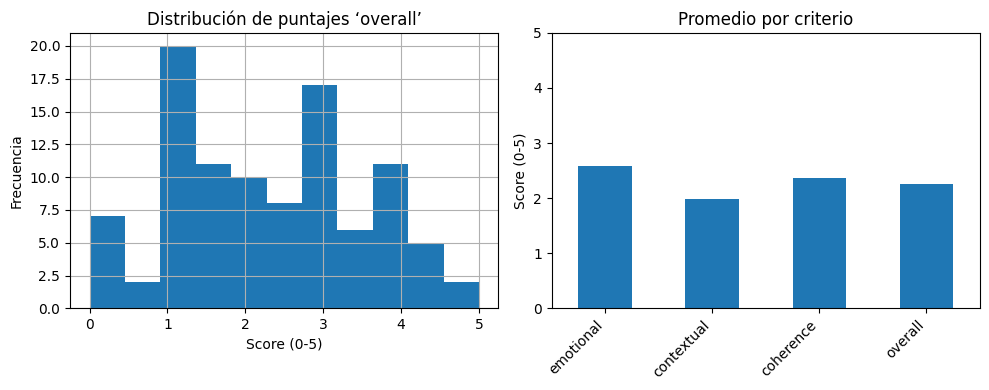

,text,lyrics_predictions,score
20,The sky finally cleared after days of rain—fee...,i can see clearly now the rain has gone i can ...,5.0
96,"I’ve been reflecting lately, and I just feel r...",i m grateful that now i can see that i am a pa...,4.7
34,Saw a clip of glowing plankton beaches and now...,i want to be on an island off the coast of mex...,4.3
23,The vet said the tests are normal—I can finall...,finally i feel calm anxiety disappeared there ...,4.3
76,I just found an old photo of my childhood home...,there s an old kodak camera in my dresser draw...,4.3


,text,lyrics_predictions,score
9,Spent a week on that proposal and it didn’t ev...,not submitted,0.0
15,Got home drenched from the rain and found a th...,jai bu un th i drank some tea taqqalahi tisnan...,0.0
14,Someone knocked on the door at midnight and th...,i ve been waiting for some time cause tonight ...,0.0
35,All morning I’ve been day-dreaming about escap...,lions in the street and roaming dogs in heat r...,0.0
50,The lights flicked back on as soon as the stor...,alighted,0.0


In [10]:
stats = df_not_filtered[[
    "emotional","contextual","coherence","overall"
]].describe().round(2)
display(stats)


plt.figure(figsize=(10, 4))

# Histograma de puntajes globales
plt.subplot(1, 2, 1)
df_not_filtered["overall"].hist(bins=11)
plt.title("Distribución de puntajes ‘overall’")
plt.xlabel("Score (0-5)")
plt.ylabel("Frecuencia")

# Barra de promedios por criterio
plt.subplot(1, 2, 2)
(df_not_filtered[[
    "emotional", "contextual", "coherence", "overall"
 ]].mean()
 ).plot(kind="bar")
plt.ylim(0, 5)
plt.title("Promedio por criterio")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score (0-5)")

plt.tight_layout()
plt.show()

# Top y bottom 5 songs recommendations
display(df_not_filtered.sort_values("overall", ascending=False)
          .head(5)[["text", "lyrics_predictions", "overall"]]
          .rename(columns={"overall": "score"}))

display(df_not_filtered.sort_values("overall", ascending=True)
          .head(5)[["text", "lyrics_predictions", "overall"]]
          .rename(columns={"overall": "score"}))